In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline


from factor_analyzer import FactorAnalyzer#EFA:它不要求你事先定义因子结构，它会基于数据自动提取因子。专门用于因子分析，提供更多与因子分析相关的功能，如旋转
from sklearn.decomposition import FactorAnalysis #EFA:主要用于降维（如PCA和因子分析），但是它不提供旋转选项

from factor_analyzer.factor_analyzer import calculate_kmo
from scipy.stats import bartlett 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import time

In [29]:
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/bge-m3-zeroshot-v2.0", use_safetensors=False) 
print('classifier loaded!')

Device set to use cpu


classifier loaded!


In [30]:
def labeliser(df,labels):
  sp=df.host_about
  res_df=pd.DataFrame()

  for i, sp in enumerate(sp):#test
    output = classifier(sp, labels, multi_label=True)

    res_courant={'sp':sp}
    labels_scores=dict(zip(output['labels'],output['scores']))
    for lab in labels :
      if lab not in res_courant:
        res_courant[lab]=labels_scores[lab]
    res_courant=pd.DataFrame(res_courant, index=[i])
    res_df=pd.concat([res_df,res_courant])

  return res_df

# EN :

In [31]:
listings_en=pd.read_csv('D:/Master_ENC/mini_memoire/data_sepa_par_langue/listings_en-others_unique.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print('len de listings_en:', len(listings_en))
print(listings_en.head())

len de listings_en: 8831
      id                         listing_url       scrape_id last_scraped  \
0   3109   https://www.airbnb.com/rooms/3109  20231212042736   2023-12-12   
1   5396   https://www.airbnb.com/rooms/5396  20231212042736   2023-12-14   
2  81106  https://www.airbnb.com/rooms/81106  20231212042736   2023-12-13   
3   7397   https://www.airbnb.com/rooms/7397  20231212042736   2023-12-13   
4   7964   https://www.airbnb.com/rooms/7964  20231212042736   2023-12-12   

        source                                               name  \
0  city scrape  Rental unit in Paris · ★5.0 · 1 bedroom · 1 be...   
1  city scrape  Rental unit in Paris · ★4.59 · Studio · 1 bed ...   
2  city scrape  Rental unit in Paris · ★4.84 · 1 bedroom · 1 b...   
3  city scrape  Rental unit in Paris · ★4.73 · 2 bedrooms · 2 ...   
4  city scrape  Rental unit in Paris · ★4.80 · 1 bedroom · 1 b...   

   description                              neighborhood_overview  \
0          NaN  Good restaur

In [ ]:
labels2tac={
    # "ingratiation_open":['love meeting new people', 'open to different cultures', 'love traveling', 'cosmopolitan', 'international view','cultural exchange','embrace new experiences'],#traveling会凹，大约可分为interactionhh和open？
    # ## 'open to exploration','discover new things'
    "ingratiation_honest":['personal life','life experiences','divers interests','hobbies','enjoy life'], #'love traveling'和interest一致，#,'family status','personal info','family'
    
    # 'ingratiation_host':['hospitable',"welcoming", 'friendly', 'sociable','interpersonal interaction'], #warm, 'out-going','easy-going'一般,'love sharing', 
    
    'enhancement_host':["attentive to needs",'thoughtful service','willing to help','responsive'],#,"explore the area","local specialities"这俩感觉不是很行
    

    
    ##'experienced in hosting',不是很好，'supportive', 'wiling to respond',
    #'offer recommendations' 效果不好?'give travel tips'备选,'give advices'类的总体太罕见
    #'be available for guests'大多数都很高，区分度低！'communicative' idem，更属于ingra_host
    ##willing to respond 没有willing to help好，proactive 更属于ingra_host? good memeories有点太selectif
    #local expert一般
    ##city相关的不怎么样！祝愿相关的不怎么样，'ensuring a good stay',"passionate about the city",'love the city',"knowledge of the city",'knowledge about'
    
    
    
    # 'enhancement_location':['central location','close to attraction', 'close to restaurants','convenient transportation','lively neighborhood'],
    # 'enhancement_equipment':["well-equipped", 'cosy place','well-decorated', 'comforsstable furniture','relaxing ambiance?'],
    # 'exemplification':["fan of Airbnb","Airbnb community"]
}    
labels_en=[label for labels in labels2tac.values() for label in labels]
print('nb de labels EN:', len(labels_en))
print(labels_en)


nb de labels EN: 10
['personal life', 'life experiences', 'divers interests', 'hobbies', 'enjoy life', 'attentive to needs', 'thoughtful service', 'willing to help', 'responsive', 'responsive and supportive']


In [ ]:
text_test=[   
    #ingratiation_open:
    "Sociable and globe trotter, I love meeting new people from all around the world. Exploring the world with a local view, is for me a great way to maintain curiosity and stay connected to different cultures, opening our mind.",
    "I love travelling and meeting new people with different backgrounds and interesting stories. I always feel very grateful for those magic moments and good vibes that people share with me. ",

    # "Très ouverte chaleureuse, toujours ravie de côtoyer d'autres personnes, d'autres cultures. Il m'est impossible de vivre sans contact, voir des amis , recevoir,  m'enrichir des connaissances des autres, m'informer sur tout.",
    # "I have traveled to more than 30 countries and I am very open to different cultures. Hope to meet you soon, during your next trip to Paris !",  
    # "J aime echanger avec les personnes que je recois et suis ouverte aux differentes cultures.",     
    # "It’s a real pleasure for me to host people coming from all over the world. I am always glad to exchange with them and to make them benefit of my passion for my city, Paris.",

    #ingratiation_host :

    #enhancement: service 
    "We understand what people need when they're away from home. Guillaume and his partners manage arrivals and checkins, adding a friendly touch to every visitor. We all genuinely love Paris and try to make it easy for people to come and visit the city.",
    "Our goal is simple: Provide a top-notch service, and have our guests feel like at home.",
       
    # "Irish guy living in Paris,love meeting new people so not only will I welcome you into my home,I'll also walk you around the local neighbourhood to give you a feel of things and explain all the bus and metro connections as well as all the local shops and supermarkets,it's a friendly residential neighbourhood so people are really easy going.",


    #tips:
    # "I am always very happy to help my guests by giving them all sort of tips for their stay in Paris, and in order to make their experience as good as possible.",
    # "If you visit Paris for the very first time the, I will tell you the places you must visit and others which are not always in the guides and that only real Parisians like me can know.",
    # "I could recommend many good addresses to drink wine , eat delicious cheese and pastries , baguettes. see amazing exhibitions,and visit  the city of champagne close to Paris ",
    "I'll be happy to help you plan your stay in Paris in whatever way I can: language questions, transport information, recommendations on sights, restaurants, clubs, cafes...etc.",
    "I could recommend many places (restaurants, shopping, bar...) in  all Paris and specially in my trendy area of the 10th arrondissement so that you experience the city like an real insider.",
    #"I know the best places of my favourite districts and will be glad to share my recommendations, tips and help you discover all the beauty and magic of Paris.",
    #"I will be very happy to help you organize your trip to Paris in advance of your stay with recommendations for eating, shopping and spending time in the area to make it as enjoyable as possible.",
    #"We will give you the best tips for your short or long parisian stay. I even run a leading event organization for international people coming to Paris; we hold events every week so you might find some nice meetup to join and mingle around.",

    #available :
    "Being available is a priority for me. It enables me to provide a high quality of service to my guests in order to make their stay peaceful and pleasant.",
    "As a SuperHost, I will make myself available to answer your needs quickly to ensure your complete well-being during your stay.",
    
    #/ask:
    #  " I encourage all potential tenant to ask all and any questions upfront. I like to clear all details concerning their stay. Even before they sign up.",
    #  " Je serai toujours disponible (moi ou un ami) pour répondre à vos questions, vous donner des conseils, des bons plans... ",
    # # 'Nous serons à votre disposition quand vous en aurez besoin pour que votre séjour soit le plus réussi.',
    # # "Don't hesitate to ask me if you have questions about your trip or Paris in general",
    # # "If you've got any questions or need any help while planning your trip to Paris I'd be very happy to lend a helping hand.",
    # # "Welcome to our home! We will make sure that you feel comfortable and have a wonderful stay with us. Please do not hesitate to ask anything to turn your visit into great souvenirs!",


    # #memorable :
    # "I am hospitable and hope that with my sincere service, I will leave good memories for your pleasant journey!",
    # "From the second you book with us to the moment you check-out, we’re here to make sure you have a smooth and comfortable stay!",
    
    # #city:
    # "I'm really enjoying sharing my knowledge and experiences of the city through the many wonderful people who've stayed as my guests through Airbnb - what a fantastic concept it is.",
    # "I enjoy traveling and meeting people from other cultures and also sharing my knowledge of Paris with my guests.",
    # "I love to discover new places in my city so if you're looking for a real experience in Paris, don't hesitate to ask i might know the exact place where you'll be comfortable and like 'at home'. ",
    # "I'm really enjoying sharing my knowledge and experiences of the city through the many wonderful people who've stayed as my guests through Airbnb - what a fantastic concept it is",
    # #干扰项：
    "L'appartement est idéalement situé proche transports et à 5 mins a pieds du Marais. Le quartier est très vivant avec des cafés, restaurants de tous genres, et un parc public. Bref vous découvrirez le quartier le plus convivial de Paris.",
   
   
    ##sd：
    "Sophie my wife, my two daughters Gabrielle, Salomé and myself live in this apartment since 2010.",
    "I'm Canadian but i've been leaving in Paris for more than 20 years.  I'm a video artist but i also teach and work as an editor.",
    "I am half Spanish and half British, I worked as a project manager until recently and now leading walking holidays around the world with a UK based company.",

    
]

print(len(text_test))
test_df=pd.DataFrame({
    'host_about':text_test
})
print('test df :',test_df)
print(len(test_df))

12
test df :                                            host_about
0   Sociable and globe trotter, I love meeting new...
1   I love travelling and meeting new people with ...
2   We understand what people need when they're aw...
3   Our goal is simple: Provide a top-notch servic...
4   I'll be happy to help you plan your stay in Pa...
5   I could recommend many places (restaurants, sh...
6   Being available is a priority for me. It enabl...
7   As a SuperHost, I will make myself available t...
8   L'appartement est idéalement situé proche tran...
9   Sophie my wife, my two daughters Gabrielle, Sa...
10  I'm Canadian but i've been leaving in Paris fo...
11  I am half Spanish and half British, I worked a...
12


In [93]:
start_time=time.time()
res_df=labeliser(test_df,labels_en)
end_time=time.time()
print('temps consummé:', end_time-start_time)

for i in range(len(test_df)):
    text=test_df.iloc[i,:].host_about
    print(f'{i}text: \n {text}\n')
res_df

##查看标签是否在和策略对应的句子中有较高分数，在其他策略

temps consummé: 52.97864103317261
0text: 
 Sociable and globe trotter, I love meeting new people from all around the world. Exploring the world with a local view, is for me a great way to maintain curiosity and stay connected to different cultures, opening our mind.

1text: 
 I love travelling and meeting new people with different backgrounds and interesting stories. I always feel very grateful for those magic moments and good vibes that people share with me. 

2text: 
 We understand what people need when they're away from home. Guillaume and his partners manage arrivals and checkins, adding a friendly touch to every visitor. We all genuinely love Paris and try to make it easy for people to come and visit the city.

3text: 
 Our goal is simple: Provide a top-notch service, and have our guests feel like at home.

4text: 
 I'll be happy to help you plan your stay in Paris in whatever way I can: language questions, transport information, recommendations on sights, restaurants, clubs, cafe

,sp,personal life,life experiences,divers interests,hobbies,enjoy life,attentive to needs,thoughtful service,willing to help,responsive,responsive and supportive
0,"Sociable and globe trotter, I love meeting new...",0.462488,0.245821,0.782134,0.939665,0.553896,0.035699,0.056135,0.037710,0.700160,0.368554
1,I love travelling and meeting new people with ...,0.898580,0.907922,0.284514,0.977687,0.927429,0.027348,0.204566,0.018341,0.284551,0.202949
2,We understand what people need when they're aw...,0.046852,0.411385,0.101138,0.000394,0.498079,0.995921,0.986909,0.859642,0.971146,0.991025
3,Our goal is simple: Provide a top-notch servic...,0.001091,0.017566,0.010145,0.000320,0.014801,0.611754,0.693544,0.410553,0.488537,0.508508
4,I'll be happy to help you plan your stay in Pa...,0.042598,0.113007,0.836293,0.000366,0.004890,0.946623,0.882410,0.988724,0.954273,0.985356
5,"I could recommend many places (restaurants, sh...",0.349015,0.645618,0.836972,0.019722,0.125336,0.785083,0.440759,0.974268,0.498092,0.683468
6,Being available is a priority for me. It enabl...,0.039565,0.032921,0.010796,0.000353,0.150711,0.818639,0.804253,0.754607,0.794872,0.823900
7,"As a SuperHost, I will make myself available t...",0.001928,0.006815,0.007552,0.000440,0.125224,0.912480,0.135416,0.965010,0.931184,0.963471
8,L'appartement est idéalement situé proche tran...,0.349159,0.845630,0.151829,0.004582,0.943381,0.402451,0.407344,0.206512,0.284575,0.777882
9,"Sophie my wife, my two daughters Gabrielle, Sa...",0.969062,0.880392,0.007513,0.000623,0.055806,0.023668,0.058354,0.019418,0.217361,0.086661


In [ ]:
# res_df.to_csv('D:/Master_ENC/mini_memoire/res_tactiques2/res_df.csv', index=False)

## conditions plus objectives :

In [48]:
labels2tac={
    # "ingratiation_open":['love meeting new people', 'open to different cultures', 'love traveling', 'cosmopolitan', 'international view','open-minded'],#traveling会凹，大约可分为interactionhh和open？
    # #open-minded 和sharing在其他文本中也会很高？可能分类不对？

    # 'ingratiation_host':['love sharing', 'hospitable',"welcoming", 'friendly', 'sociable','interpersonal interaction'], #warm, 'out-going','easy-going'一般

    # #之前是service, experienced in hosting, attentif to needs
    # #service太宽泛了！superhost先不进行ZSC，减轻负担，而且和我的原意有偏离;感觉可以分为内外两个？
    # 'enhancement_host':['experienced host',"attentive to needs",'thoughtful service','offer recommendations'],#,"explore the area","local specialities"这俩感觉不是很行
    
    # 'enhancement_location':['central location','close to attraction', 'close to restaurants','close to transport connections','easily accessible','lively neighborhood'],#or lively/animé?
    # 'enhancement_equipment':["well-equipped",'well-decorated','well-maintained','cosy place','comfortable atmosphere','feel like home'],
    
    'exemplification':["fan of Airbnb","Airbnb community", "love Airbnb","travel with Airbnb"]
}    

labels_en=[label for labels in labels2tac.values() for label in labels]
print('nb de labels EN:', len(labels_en))
print(labels_en)

nb de labels EN: 4
['fan of Airbnb', 'Airbnb community', 'love Airbnb', 'travel with Airbnb']


In [46]:
text_test=[ 
    #quartier :
    "Jerome and I are living in the neighborhood/quartier since 2005. And we love it ! Sure you will too !",#neighorhood
    "We love to travel around the world, and occasionally rent our funky home in the groovy neighborhood 'Beaubourg / Le Marais' when we leave Paris.",
    "C'est un quartier résidentiel, très sûr, où il fait bon vivre. En même temps, il est très proche de lieux touristiques majeurs (Tour Eiffel, Champs Elysées),.",    
        
    # ##lcoation :
    "L'appartement est idéalement situé proche transports et à 5 mins a pieds du Marais. Le quartier est très vivant avec des cafés, restaurants de tous genres, et un parc public. Bref vous découvrirez le quartier le plus convivial de Paris.",#***
    "Ideally situated at 5mins by walk to the Marais or Place des Vosges, all transports bus or metro to go to different closed sites, you will love this neighborhood with lots of cafés and restaurants, a public park.",

    #transport:
    'One can walk everywhere,Not only is the subway at the door; every bus is just feet away.'

    # #decoration & cosy:
    # "Super charming and super cozy, quiet and quaintly decorated 2 bedroom (50m2) bohemian apartment for rent in hip Belleville area of northern Paris",
    # "When in Paris, I work from my home, so let's say I've spent quite some times making it a place I want to spend time in, cozy, calm, with a lot of sunlight.",
    # " My interior has a vintage touch, its a loft-  If you like cosy and warmth place- this is the place. ",
    # "As I said, this apartment is my home. It's not a rental investment with cheap standard stuff, but equipped with finely collected items and artifacts that I have found all over the world and fine-tuned over the years.",
    # "I've taken a lot of care and paid a lot of attention in re-decorating and equipping it to make it the perfect pad from which to explore Paris...",

    # #equipement :
    # "The size is amazing for Paris : 120m² (1400 square feet), 3 bedrooms appartment, double living room (not like in other flats, where the living room is used as a bedroom...), 2 bathrooms, independent kitchen.",
    # "All our flats are designed and fully furnished. They will be your perfect second home in Paris. ", 
    # "Most of our Apartments have:  FREE WIFI, FREE LONG DISTANCE TELEPHONE, CABLE TV, PARIS MOVIES, PARIS GUIDE BOOKS, PRIVATE KITCHEN & BATHS, and more!",

    # #clean:
    # "The Manager keeps the apt very very very clean; and with Covid-19 it is disinfected each time she cleans. "

    #ab:
    #love 
    "So I am very attentive to the decoration of my apartment and very pleased to offer thanks to Airbnb.",
    "It would be a pleasure to meet you and make you discover the lovely neighborhood. I think Airbnb is the perfect place to meet interesting people.",#ab!
    #"In 2011 we tried Airbnb for a business trip to San Francisco and have never looked back to hotels.  We decided to renovate a little studio on top of our apartment. Since then have been the lucky hosts of many wonderful guests, we love meeting so many people from all over the world and feel lucky to belong to such a special community!",
    #"After several experiences as an Airbnb host in NYC and delightful meetings as a guest all over the world, I now welcome people in my new apartment located in the heart of Paris. ",
    "We do like to travel, meet and mainly welcome people who coming from all over the World! That is why Airbnb is wonderful for that...",
  
    
    #travel with:
    "We are web startup entrepreneurs and bnb/gardener entrepreneurs, and either work from home (in Brittany) or in Paris. Airbnb gives us the opportunity to live both lifes.",
    "I hope i will travel soon in many parts of France and all other the world with airbnb!",
    "We particularly like experiencing the flavour of the real for example with Airbnb hosts who like us rent their own family house.",
    "Airbnb is new for me and I really look forward to meeting some of you coming to Paris!",
    "I love to travel and I use Airbnb a lot during my trips.",

    #why :
    "I also love to meet new people and share their life experiences. That's why I use airbnb.",
    "Sometimes, the job is  far outside Paris reason why my apartment is on Airbnb.",
    "As you read this, I'm sure I'm out visting some friends outside of Paris :-). That's why I rent my apartment when I'm not in the city of lights.",
    "I travel a lot for my work that's why I have decided to rent my two lovely places"
]


print(len(text_test))
test_df=pd.DataFrame({
    'host_about':text_test
})
print('test df :',test_df)
print(len(test_df))

17
test df :                                            host_about
0   Jerome and I are living in the neighborhood/qu...
1   We love to travel around the world, and occasi...
2   C'est un quartier résidentiel, très sûr, où il...
3   L'appartement est idéalement situé proche tran...
4   Ideally situated at 5mins by walk to the Marai...
5   One can walk everywhere,Not only is the subway...
6   It would be a pleasure to meet you and make yo...
7   We do like to travel, meet and mainly welcome ...
8   We are web startup entrepreneurs and bnb/garde...
9   I hope i will travel soon in many parts of Fra...
10  We particularly like experiencing the flavour ...
11  Airbnb is new for me and I really look forward...
12  I love to travel and I use Airbnb a lot during...
13  I also love to meet new people and share their...
14  Sometimes, the job is  far outside Paris reaso...
15  As you read this, I'm sure I'm out visting som...
16  I travel a lot for my work that's why I have d...
17


In [47]:
start_time=time.time()
res_df=labeliser(test_df,labels_en)
end_time=time.time()
print('temps consummé:', end_time-start_time)

for i in range(len(test_df)):
    text=test_df.iloc[i,:].host_about
    print(f'{i}text: \n {text}\n')

res_df

temps consummé: 30.52831506729126
0text: 
 Jerome and I are living in the neighborhood/quartier since 2005. And we love it ! Sure you will too !

1text: 
 We love to travel around the world, and occasionally rent our funky home in the groovy neighborhood 'Beaubourg / Le Marais' when we leave Paris.

2text: 
 C'est un quartier résidentiel, très sûr, où il fait bon vivre. En même temps, il est très proche de lieux touristiques majeurs (Tour Eiffel, Champs Elysées),.

3text: 
 L'appartement est idéalement situé proche transports et à 5 mins a pieds du Marais. Le quartier est très vivant avec des cafés, restaurants de tous genres, et un parc public. Bref vous découvrirez le quartier le plus convivial de Paris.

4text: 
 Ideally situated at 5mins by walk to the Marais or Place des Vosges, all transports bus or metro to go to different closed sites, you will love this neighborhood with lots of cafés and restaurants, a public park.

5text: 
 One can walk everywhere,Not only is the subway at t

,sp,fan of Airbnb,Airbnb community,love Airbnb,travel with Airbnb,why rent on Airbnb
0,Jerome and I are living in the neighborhood/qu...,0.006981,0.017109,0.006609,0.000890,0.004853
1,"We love to travel around the world, and occasi...",0.036233,0.023579,0.015782,0.100282,0.032361
2,"C'est un quartier résidentiel, très sûr, où il...",0.009130,0.016946,0.022758,0.105679,0.053431
3,L'appartement est idéalement situé proche tran...,0.069491,0.127322,0.058853,0.850966,0.547207
4,Ideally situated at 5mins by walk to the Marai...,0.018211,0.005194,0.010007,0.018759,0.040306
5,"One can walk everywhere,Not only is the subway...",0.964671,0.959393,0.829761,0.975869,0.949380
6,It would be a pleasure to meet you and make yo...,0.982971,0.963645,0.845314,0.829288,0.365475
7,"We do like to travel, meet and mainly welcome ...",0.989247,0.989385,0.960149,0.918024,0.969802
8,We are web startup entrepreneurs and bnb/garde...,0.447961,0.959822,0.047886,0.177360,0.607730
9,I hope i will travel soon in many parts of Fra...,0.975044,0.857979,0.738497,0.964337,0.929619


## self discolure : family, job, interest:==> ingratiation_person


In [ ]:
#ingra: enjoy life?
#life values','life style','enjoy life'


labels_sd=["personal info","personal life",'life experiences','occupation','profession',"work field", 'family', "nationality",'passions', 'hobbies','interests']
texts_sd=[
    "I'm 33, live with my husband and baby boy in Paris. We are originally from Tel Aviv and recently arrived to Paris. Luckily, we have found our home in the lovely neighborhood Butte aux Cailles. " ,#life experience, nationality
    "We are a French family of four. My wife is a university professor, specialized in language acquisition and I am the assistant of a film director in Paris. ",#work
    "We are web startup entrepreneurs and bnb/gardener entrepreneurs, and either work from home (in Brittany) or in Paris. Airbnb gives us the opportunity to live both lifes.",
    "I'm Canadian but i've been leaving in Paris for more than 20 years.  I'm a video artist but i also teach and work as an editor.",
    "I am half Spanish and half British, I worked as a project manager until recently and now leading walking holidays around the world with a UK based company.",
    "I am a sound engineer. I love music. I play drums in a band.",
    "I am a Native New Yorker (yes, I was born and raised here!) and have lived in Boston, Paris and Los Angeles and speak a bit of French and Spanish and about two words of Italian. I work in the legal field. I went to culinary school to study pastry many years ago and now I just bake cookies at Christmas when I have the time!",

    "I have traveled to over 60 countries, go away to my house in Pennsylvania on many weekends and like meeting new people. ",
    "I am a writer,54, author of novels, books of linguistics...",
    "I love food, art, architecture, the sea/ocean, dancing and laughter.",
    
    
    "I'm really enjoying sharing my knowledge and experiences of the city through the many wonderful people who've stayed as my guests through Airbnb - what a fantastic concept it is.",
    "Welcome to Paris, and hope you will enjoying my apartment during your stay. Besides, I can give you some advices if you're first time in Paris!"
]

print(len(labels_sd))
print(len(texts_sd))
test_df=pd.DataFrame({
    'host_about':texts_sd
})
print('test df :',test_df)
print(len(test_df))

13
9
test df :                                           host_about
0  I'm 33, live with my husband and baby boy in P...
1  We are a French family of four. My wife is a u...
2  We are web startup entrepreneurs and bnb/garde...
3  I'm Canadian but i've been leaving in Paris fo...
4  I am half Spanish and half British, I worked a...
5  I am a sound engineer. I love music. I play dr...
6  I love food, art, architecture, the sea/ocean,...
7  I'm really enjoying sharing my knowledge and e...
8  Welcome to Paris, and hope you will enjoying m...
9


In [7]:
start_time=time.time()
res_df=labeliser(test_df,labels_sd)
end_time=time.time()
print('temps consummé:', end_time-start_time)

for i in range(len(test_df)):
    text=test_df.iloc[i,:].host_about
    print(f'{i}text: \n {text}\n')
    
res_df

temps consummé: 34.43952751159668
0text: 
 I'm 33, live with my husband and baby boy in Paris. We are originally from Tel Aviv and recently arrived to Paris. Luckily, we have found our home in the lovely neighborhood Butte aux Cailles. 

1text: 
 We are a French family of four. My wife is a university professor, specialized in language acquisition and I am the assistant of a film director in Paris. 

2text: 
 We are web startup entrepreneurs and bnb/gardener entrepreneurs, and either work from home (in Brittany) or in Paris. Airbnb gives us the opportunity to live both lifes.

3text: 
 I'm Canadian but i've been leaving in Paris for more than 20 years.  I'm a video artist but i also teach and work as an editor.

4text: 
 I am half Spanish and half British, I worked as a project manager until recently and now leading walking holidays around the world with a UK based company.

5text: 
 I am a sound engineer. I love music. I play drums in a band.

6text: 
 I love food, art, architecture, 

,sp,willing to help,willing to share,personal info,personal life,life experiences,occupation,profession,work field,family,nationality,passions,hobbies,personal interests
0,"I'm 33, live with my husband and baby boy in P...",0.039007,0.961008,0.997298,0.995785,0.996858,0.032585,0.002141,0.000645,0.977058,0.881987,0.025646,0.000618,0.901748
1,We are a French family of four. My wife is a u...,0.327068,0.756869,0.932358,0.191164,0.782334,0.843159,0.506928,0.836264,0.992160,0.973567,0.006912,0.017715,0.027526
2,We are web startup entrepreneurs and bnb/garde...,0.125267,0.887436,0.741204,0.066842,0.864157,0.682752,0.600048,0.737248,0.007199,0.633164,0.248234,0.011806,0.207221
3,I'm Canadian but i've been leaving in Paris fo...,0.133390,0.851857,0.956024,0.550487,0.951763,0.964487,0.930500,0.937917,0.004987,0.959726,0.787736,0.572049,0.494506
4,"I am half Spanish and half British, I worked a...",0.092335,0.854891,0.920178,0.072309,0.959220,0.855644,0.648736,0.674264,0.003452,0.947363,0.035781,0.699823,0.016606
5,I am a sound engineer. I love music. I play dr...,0.119320,0.875236,0.957074,0.060676,0.076680,0.773595,0.908159,0.871939,0.001321,0.058433,0.979273,0.847184,0.866197
6,"I love food, art, architecture, the sea/ocean,...",0.016533,0.889790,0.962845,0.816079,0.722833,0.053388,0.002995,0.055966,0.001858,0.136377,0.992386,0.986909,0.991119
7,I'm really enjoying sharing my knowledge and e...,0.238133,0.987944,0.104591,0.016616,0.093880,0.005089,0.009752,0.003527,0.003194,0.053564,0.231485,0.013158,0.399497
8,"Welcome to Paris, and hope you will enjoying m...",0.975532,0.936123,0.438933,0.124815,0.044739,0.196844,0.005813,0.000639,0.007683,0.200946,0.005008,0.000326,0.106196


## reorganiser la dataset & EFA :

In [94]:
import pandas as pd
res_en=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en2.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_en.columns)

res_en_comple2=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en_comple2.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_en_comple2.columns)

res_en_comple3=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en_comple3.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_en_comple3.columns)

res_en_comple4=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en_comple4.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_en_comple4.columns)

res_en_comple5=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en_comple5.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_en_comple5.columns)

res_en_comple6=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en_comple6.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_en_comple6.columns)

res_en_comple7=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en_comple7.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_en_comple7.columns)

res_en_comple8=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en_comple8.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_en_comple8.columns)

Index(['sp', 'meet new people', 'open to different cultures', 'hospitable',
       'welcoming', 'interaction', 'service', 'experienced in hosting',
       'attentive to needs', 'central location', 'close to attraction',
       'well-equipped', 'cosy place', 'well-decorated', 'superhost',
       'fan of Airbnb', 'Airbnb community'],
      dtype='object')
Index(['sp', 'open-minded', 'sharing with others', 'love traveling',
       'cosmopolitan', 'international view'],
      dtype='object')
Index(['sp', 'love sharing', 'friendly', 'sociable',
       'interpersonal interaction', 'experienced host', 'thoughtful service',
       'offer recommendations'],
      dtype='object')
Index(['sp', 'give advices', 'be available for guests',
       'responsive and supportive', 'close to restaurants',
       'convenient transportation', 'easily accessible', 'lovely neighborhood',
       'well-maintained', 'comfortable atmosphere'],
      dtype='object')
Index(['sp', 'cultural exchange', 'embrace new exp

In [ ]:
#先把多个合并在一起：
res_en_merged=pd.concat([ res_en, res_en_comple2, res_en_comple3, res_en_comple4, res_en_comple5, res_en_comple6, res_en_comple7, res_en_comple8], axis=1)

res_en_merged = res_en_merged.loc[:, ~res_en_merged.columns.duplicated()]

print(len(res_en_merged.columns))
print(res_en_merged.columns)


65
Index(['sp', 'meet new people', 'open to different cultures', 'hospitable',
       'welcoming', 'interaction', 'service', 'experienced in hosting',
       'attentive to needs', 'central location', 'close to attraction',
       'well-equipped', 'cosy place', 'well-decorated', 'superhost',
       'fan of Airbnb', 'Airbnb community', 'open-minded',
       'sharing with others', 'love traveling', 'cosmopolitan',
       'international view', 'love sharing', 'friendly', 'sociable',
       'interpersonal interaction', 'experienced host', 'thoughtful service',
       'offer recommendations', 'give advices', 'be available for guests',
       'responsive and supportive', 'close to restaurants',
       'convenient transportation', 'easily accessible', 'lovely neighborhood',
       'well-maintained', 'comfortable atmosphere', 'cultural exchange',
       'embrace new experiences', 'supportive', 'willing to help', 'proactive',
       'wish you a good time', 'close to transport connections',
     

In [119]:
# correct_order = ['sp', 'open to different cultures', 'love traveling', 'cosmopolitan', 'international view',
#                  'meet new people', 'love sharing', 'hospitable', 'welcoming', 'friendly','sociable', 'interpersonal interaction', 
#                  'experienced in hosting','thoughtful service', 'attentive to needs','give advices','be available for guests','responsive and supportive','superhost',#'superhost',#'offer recommendations',
#                  'central location', 'close to attraction','close to restaurants', 'lovely neighborhood','convenient transportation', 'easily accessible', 
#                  'well-equipped', 'well-decorated',"well-maintained", 'comfortable atmosphere','cosy place',# "well-maintained", 
#                  'fan of Airbnb', 'Airbnb community']


# correct_order = ['sp', 'open to different cultures', 'love traveling', 'cosmopolitan', 'international view', 'cultural exchange','embrace new experiences',##添加'clture exchange','embrace new experiences'
#                  'meet new people', 'love sharing', 'hospitable', 'welcoming', 'friendly','sociable', 'interpersonal interaction', 'be available for guests','responsive and supportive',##移动 'be available for guests','responsive and supportive'至ingra
#                  'experienced host','thoughtful service', 'attentive to needs','give advices','supportive', 'willing to help', 'proactive', 'wish you a good time', 'superhost',#'superhost',#'offer recommendations',#添加'supportive','willing to respond', 'willing to help', 'proactive', 'create memorable experiences' too specific;'willing to respond'暂时没加！
#                  'central location', 'close to attraction','close to restaurants','close to transport connections','easily accessible','lively neighborhood', #删除+增加 transportation connections, livelu
#                  'well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere','feel like home',# "well-maintained"? 增加feel like home
#                  'fan of Airbnb', 'Airbnb community']



# correct_order = ['sp', 'open to different cultures', 'love traveling', 'cosmopolitan', 'international view','cultural exchange','embrace new experiences','proactive','love sharing','supportive', ##'clture exchange'0.45??还行但也不太好,添加'embrace new experiences', 接收'proactive'+'love sharing',
#                  'meet new people', 'hospitable', 'welcoming', 'friendly','sociable', 'interpersonal interaction', ##接收'be available for guests'又删去,'responsive and supportive'/supportive, 'love sharing'删去
#                  'experienced host','thoughtful service', 'attentive to needs','give advices','willing to help',
#                  #'superhost'不好,#'offer recommendations',#添加'supportive','willing to respond', 'willing to help', 'proactive', 'create memorable experiences' 
#                  # memories too specific;'willing to respond'暂时没加！删去 'wish you a good time'


#                  'central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood', #删除convenient, accessible 增加 transportation connections, lively
#                  'well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere',# "well-maintained"? 增加feel like home不太好所以删去
#                  'fan of Airbnb', 'Airbnb community']

#04/04/25
labels2tac={
    "ingratiation_open":['open to different cultures', 'cosmopolitan','international view','cultural exchange'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2，proactive出现交叉载荷！
    #'embrace new experiences'低，先取出
    "ingratiation_honest":['personal life','life experiences','divers interests','hobbies','enjoy life'], #'love traveling'和interest一致，#,'family status','personal info','family'
    #'occupation', 'profession', 'work field'工作针对性太强，无法归于策略！'nationality'同理
    'ingratiation_host':['meet new people', 'welcoming', 'friendly','sociable', 'interpersonal interaction'],#'hospitable'有点交叉载荷，先去除
    'enhancement_host':['thoughtful service', 'attentive to needs','willing to help','responsive'],#'give advices','experienced host','love sharing'
    'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
    'enhancement_equipment':['well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere'],
    'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']    
}    

labels_en=['sp']
labels_en_=[label for labels in labels2tac.values() for label in labels]
labels_en.extend(labels_en_)
correct_order=labels_en

print('CORRECT ORDER:',len(correct_order))
print(correct_order)



correct_columns = [col for col in correct_order if col in res_en_merged.columns]
print(len(correct_columns))

res_en_ = res_en_merged[correct_columns]
print(res_en_.columns)
res_en_.to_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en5.csv',index=False)#STOCKER!!!!
##res_en_是合并+整理过顺序的res_zsc!!!

CORRECT ORDER: 33
['sp', 'open to different cultures', 'cosmopolitan', 'international view', 'cultural exchange', 'personal life', 'life experiences', 'divers interests', 'hobbies', 'enjoy life', 'meet new people', 'welcoming', 'friendly', 'sociable', 'interpersonal interaction', 'thoughtful service', 'attentive to needs', 'willing to help', 'responsive', 'central location', 'close to attraction', 'close to restaurants', 'close to transport connections', 'lively neighborhood', 'well-equipped', 'well-decorated', 'well-maintained', 'cosy place', 'comfortable atmosphere', 'fan of Airbnb', 'Airbnb community', 'love Airbnb', 'travel with Airbnb']
33
Index(['sp', 'open to different cultures', 'cosmopolitan',
       'international view', 'cultural exchange', 'personal life',
       'life experiences', 'divers interests', 'hobbies', 'enjoy life',
       'meet new people', 'welcoming', 'friendly', 'sociable',
       'interpersonal interaction', 'thoughtful service', 'attentive to needs',
      

Index(['open to different cultures', 'cosmopolitan', 'international view',
       'cultural exchange', 'personal life', 'life experiences',
       'divers interests', 'hobbies', 'enjoy life', 'meet new people',
       'welcoming', 'friendly', 'sociable', 'interpersonal interaction',
       'thoughtful service', 'attentive to needs', 'willing to help',
       'responsive', 'central location', 'close to attraction',
       'close to restaurants', 'close to transport connections',
       'lively neighborhood', 'well-equipped', 'well-decorated',
       'well-maintained', 'cosy place', 'comfortable atmosphere',
       'fan of Airbnb', 'Airbnb community', 'love Airbnb',
       'travel with Airbnb'],
      dtype='object')


Text(0.5, 1.0, 'scores des labels')

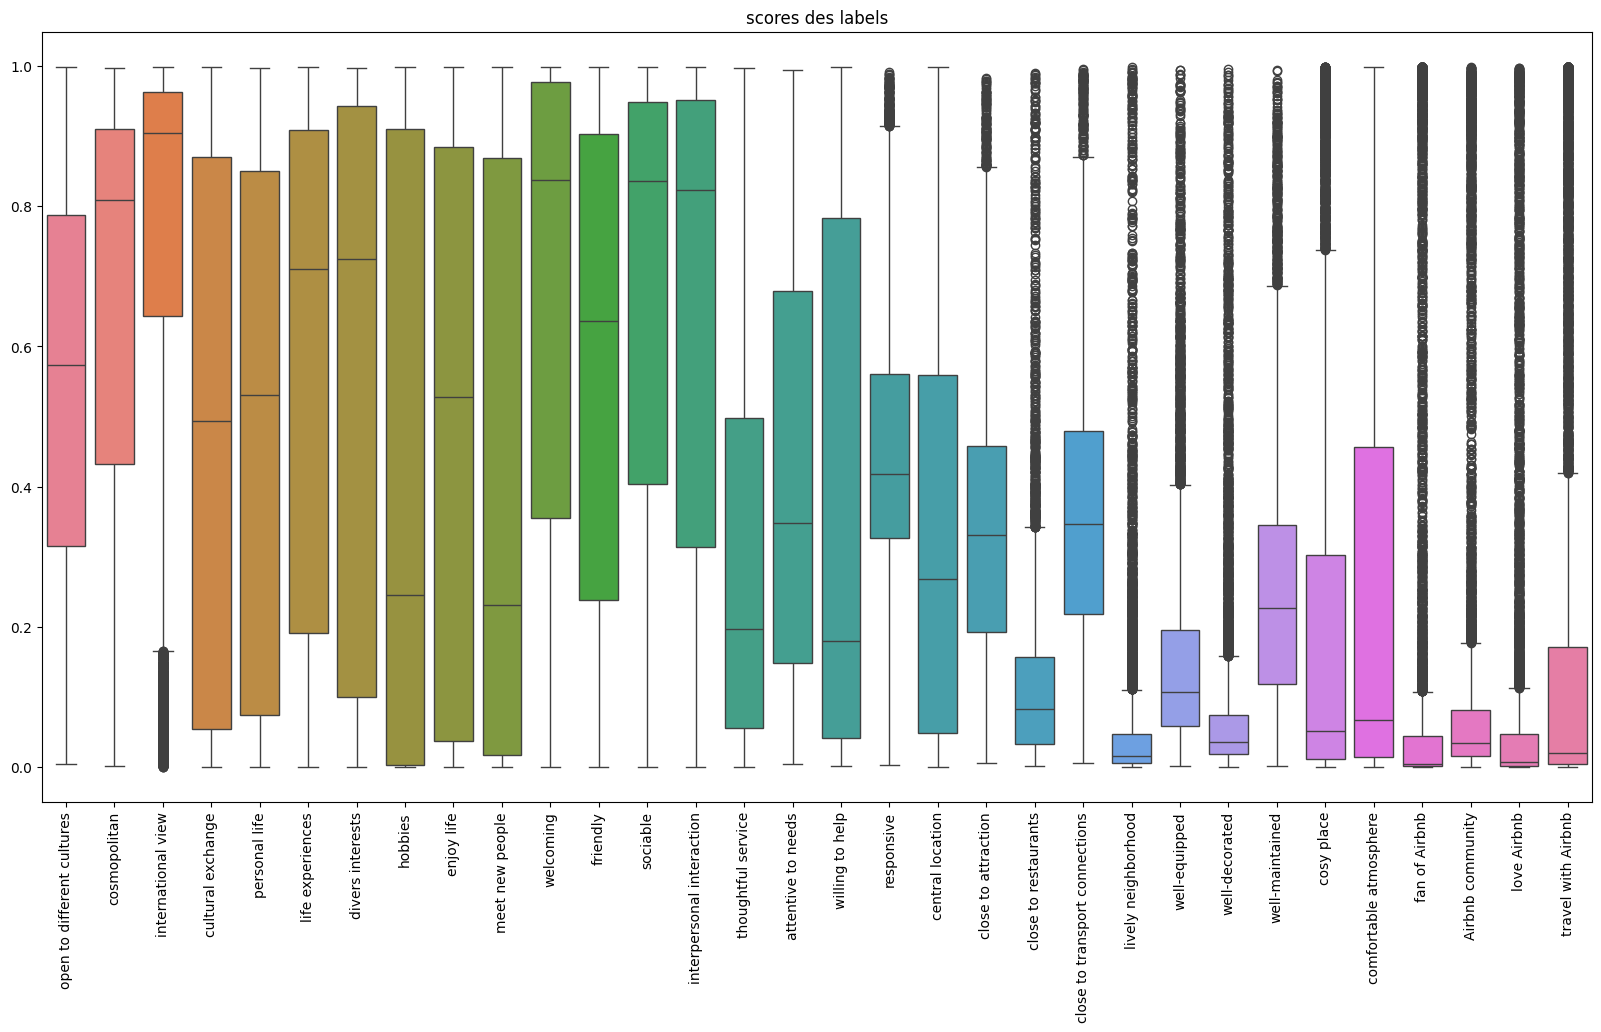

In [120]:
##查看分布：筛除分布异常的:过低或者异常值过多！
import matplotlib.pyplot as plt
import seaborn as sns 

data=res_en_.drop(columns='sp')
print(data.columns)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.boxplot(data)
plt.title('scores des labels')
#plt.savefig('D:/Master_ENC/mini_memoire/res_tactiques2/result_en4_boxenplot.jpg',dpi=300)

## personal区块很大，但是平均值不是很高？

In [121]:
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

data=res_en_.drop(columns='sp')
# KMO 检验
kmo_all, kmo_model = calculate_kmo(data)
print(f"KMO Measure: {kmo_model:.2f}")

# Bartlett 球形检验
chi_square_value, p_value = calculate_bartlett_sphericity(data)
print(f"Bartlett's test chi-square: {chi_square_value:.2f}, p-value: {p_value:.3f}")


KMO Measure: 0.88
Bartlett's test chi-square: 204818.76, p-value: 0.000


d:\miniconda3\envs\transformers_env\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


d:\miniconda3\envs\transformers_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,F1,F2,F3,F4,F5,F6,F7
open to different cultures,0.181840,0.043632,0.050360,0.011124,0.751554,0.061516,-0.082305
cosmopolitan,0.045163,-0.024038,0.158651,-0.031895,0.691307,-0.063890,0.180825
international view,0.035968,0.080887,0.006545,-0.023991,0.836457,0.044256,0.039405
cultural exchange,0.219922,-0.099081,0.087642,-0.079730,0.489159,0.000659,0.068765
personal life,0.187146,0.158078,0.590203,-0.101194,-0.059725,-0.001357,0.173999
life experiences,-0.016100,0.144782,0.534260,-0.081562,0.117974,0.025484,0.245344
divers interests,-0.163289,-0.046419,0.685185,0.193998,0.299035,-0.007381,0.031461
hobbies,-0.039987,-0.051427,0.806563,0.004905,0.083099,-0.094997,-0.093630
enjoy life,0.147217,0.011290,0.811792,-0.122673,-0.051050,0.127846,-0.011696
meet new people,0.671677,-0.050255,-0.052679,-0.101970,0.294808,-0.080502,-0.069286


<Axes: >

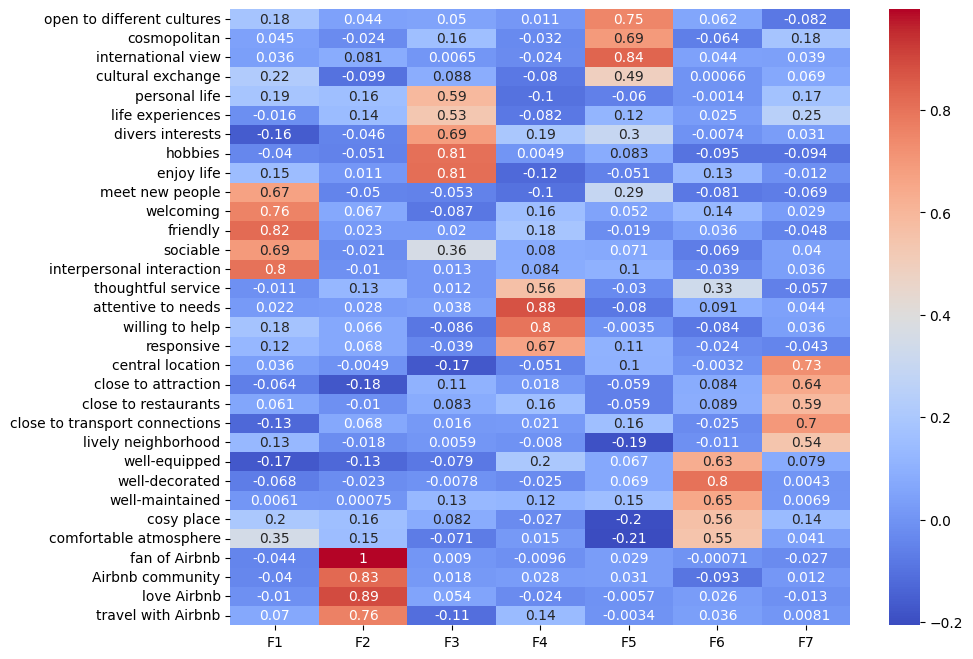

In [122]:
from factor_analyzer import FactorAnalyzer 
data=res_en_.drop(columns='sp')

fa = FactorAnalyzer(n_factors=7, rotation="oblimin")#permet la corrélation entre des facteurs!!
fa.fit(data)

loadings=fa.loadings_
loadings_df = pd.DataFrame(loadings, index=data.columns, columns=["F1", "F2","F3",'F4','F5','F6','F7'])

display(loadings_df)

#loadings_df.to_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/4factor_loading_7_en_oblimin36.csv', index=True)


import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(10,8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Explained variance ratio:0.4123390106308831


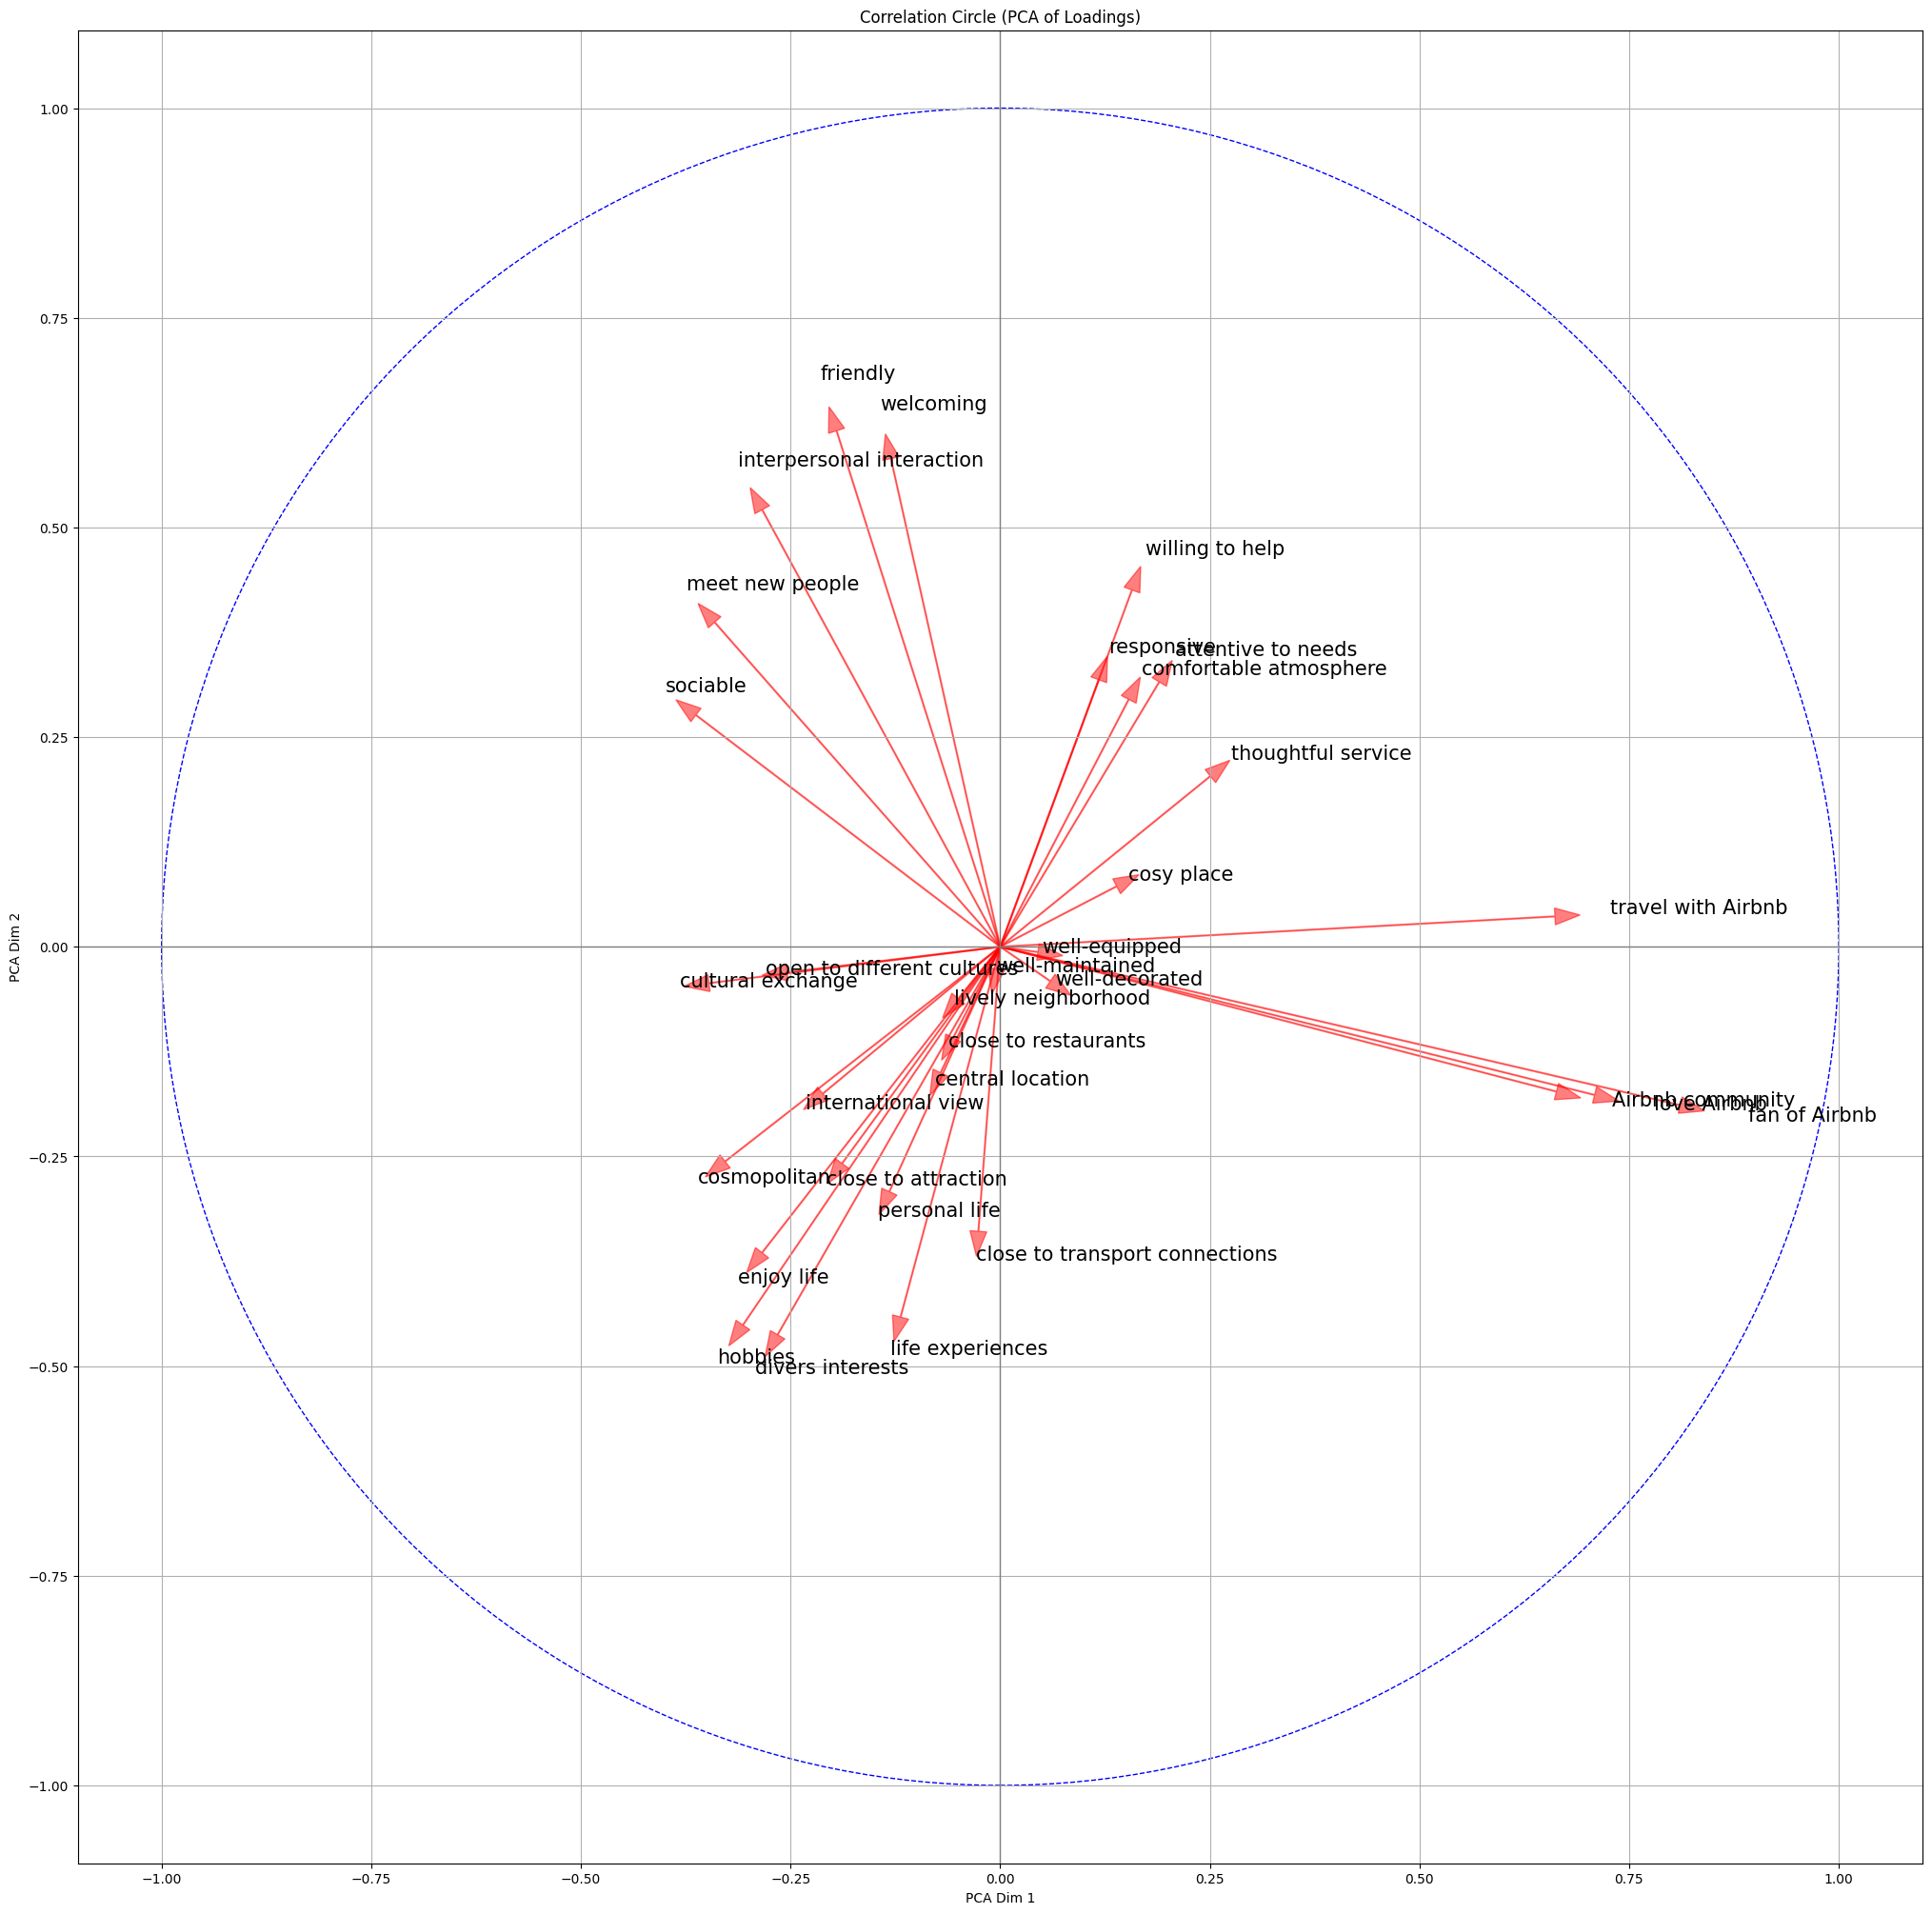

In [123]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca=PCA(n_components=2)
loadings_2d=pca.fit_transform(loadings)
print(f"Explained variance ratio:{pca.explained_variance_ratio_.sum()}")

plt.figure(figsize=(25, 25))
# 画单位圆
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# 坐标轴
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# PCA画箭头
for i, var in enumerate(data.columns):
    plt.arrow(0, 0, loadings_2d[i, 0], loadings_2d[i, 1], 
              color='red', alpha=0.5, head_width=0.02)
    plt.text(loadings_2d[i, 0]*1.1, loadings_2d[i, 1]*1.1, var, fontsize=15)


plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Correlation Circle (PCA of Loadings)')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='datalim')
plt.show()

Explained variance ratios (3D): 0.5965095091856893


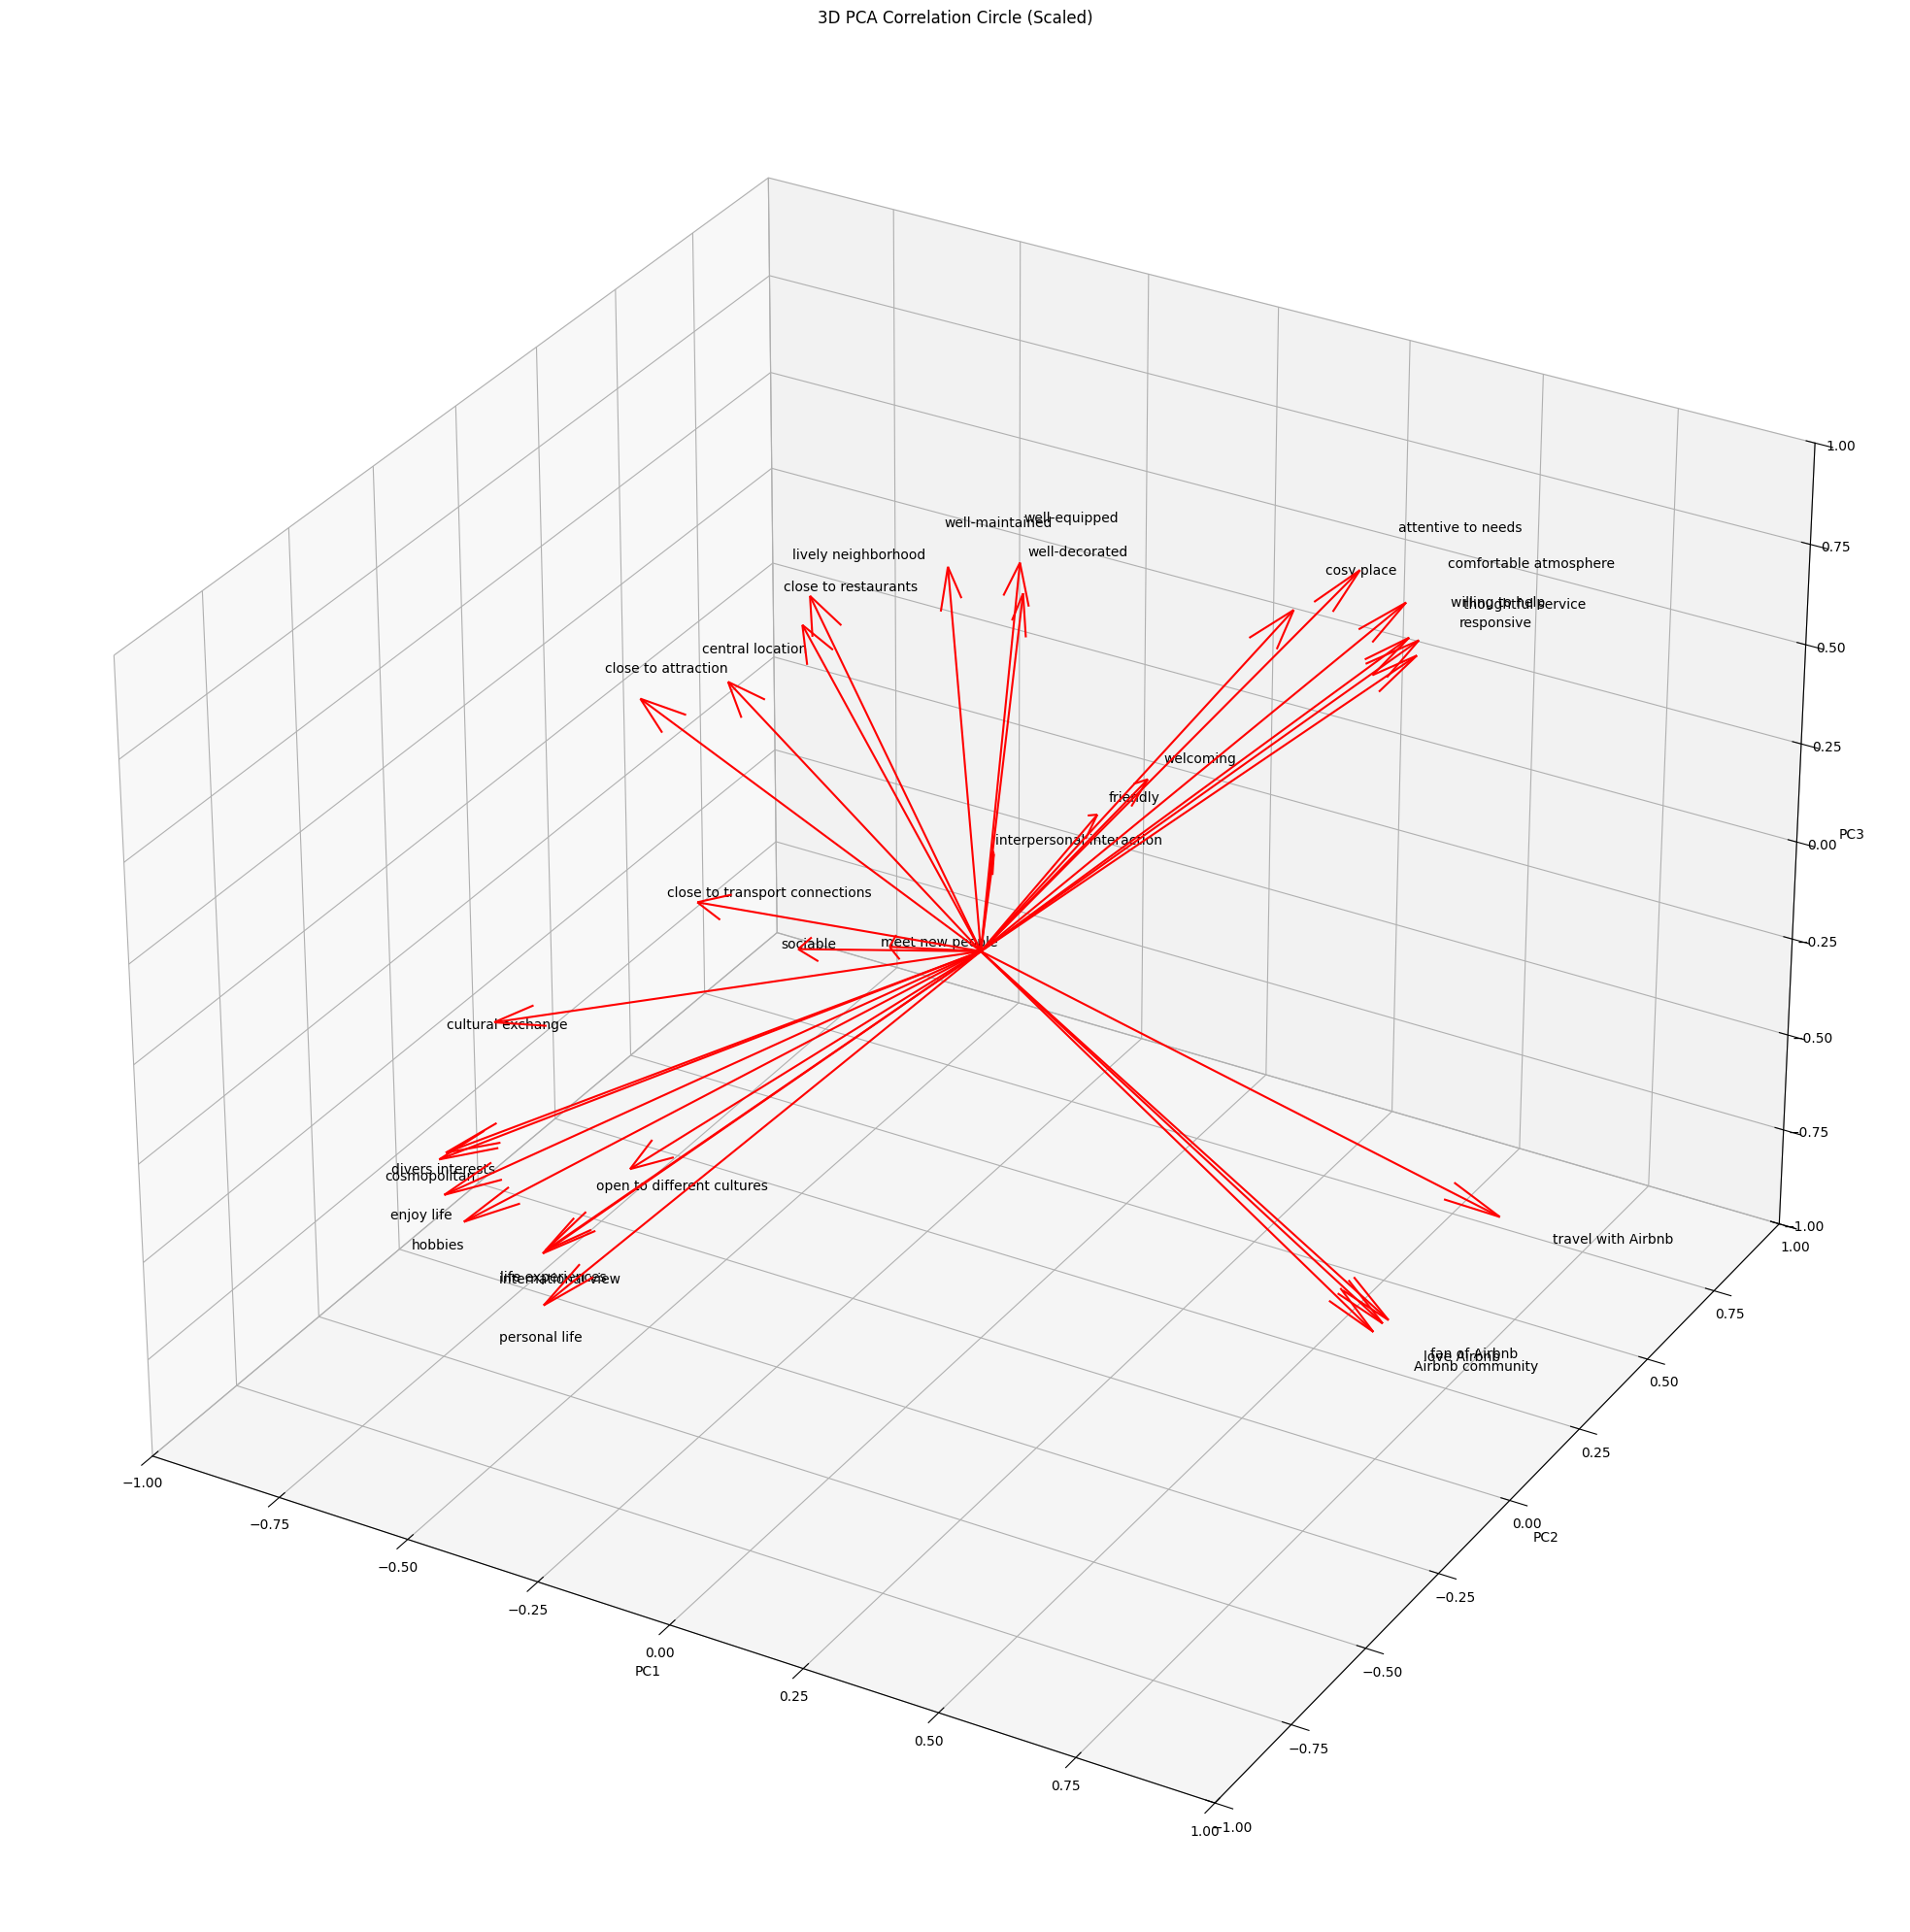

In [124]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_3d=PCA(n_components=3)
loadings_3d=pca_3d.fit_transform(loadings)



fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')


# 缩放向量
norms = np.linalg.norm(loadings_3d, axis=1)
loadings_3d_scaled = loadings_3d / norms[:, np.newaxis] #0.8
print("Explained variance ratios (3D):", pca_3d.explained_variance_ratio_.sum())


# 画箭头
for i, var in enumerate(data.columns):
    ax.quiver(0, 0, 0,
              loadings_3d_scaled[i, 0], 
              loadings_3d_scaled[i, 1], 
              loadings_3d_scaled[i, 2], 
              color='red', arrow_length_ratio=0.1)
    
    ax.text(loadings_3d_scaled[i, 0]*1.1, 
            loadings_3d_scaled[i, 1]*1.1, 
            loadings_3d_scaled[i, 2]*1.1, 
            var, fontsize=10)

# 坐标轴限制
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title('3D PCA Correlation Circle (Scaled)')
plt.tight_layout()
#plt.savefig(f'D:/Master_ENC/mini_memoire/res_tactiques2/4factor_loading_{n_tactics}_enfr_oblimin{n_labels}_cc3D.jpg', dpi=300)
plt.show()

## fusionner + EFA again :

In [14]:
loadings_df.rename(columns={"Unnamed: 0":'labels',
                         'F1':"ingratiation_host",
                         "F2":"exemplification",
                         "F3":"ingratiation_personal",
                         "F4":"ingratiation_open",
                         "F5":"enhancement_host",
                         "F6":"enhancement_location", 
                         "F7":"enhancement_equipment"
                         }, inplace=True)
display(loadings_df)

,ingratiation_host,exemplification,ingratiation_personal,ingratiation_open,enhancement_host,enhancement_location,enhancement_equipment
open to different cultures,0.184164,0.068211,-0.035024,0.785019,-0.036103,0.081908,-0.044589
cosmopolitan,-0.009285,-0.045721,0.172009,0.712513,0.025145,-0.073101,0.175450
international view,-0.015455,0.063211,0.037183,0.799643,0.074598,-0.008267,0.064553
cultural exchange,0.193167,-0.109785,0.066845,0.483782,-0.039059,-0.031444,0.089721
embrace new experiences,0.224752,0.092951,0.322817,0.508203,0.023640,0.123552,-0.109846
personal info,0.111385,-0.005155,0.651367,0.102282,0.079279,-0.100749,0.138600
personal life,0.073150,0.064396,0.817746,-0.114448,0.034434,-0.067900,0.068677
life experiences,-0.167264,0.049036,0.724850,0.106515,0.125333,-0.042330,0.153006
hobbies,-0.042457,-0.064319,0.608706,0.242636,-0.150818,0.052350,-0.164324
enjoy life,0.094897,-0.028745,0.698468,0.077327,-0.193365,0.219618,-0.096594


In [25]:
labels_list=[label for labels in labels2tac.values() for label in labels]
print('LABEL LIST:',labels_list)


label2loading={}
for tactic, labels in labels2tac.items() :
    for label in labels :
        idx_label=list(labels_list).index(label)
        loading=loadings_df[tactic][idx_label]
        if label not in label2loading:
            label2loading[label]=loading
       
print(label2loading)

LABEL LIST: ['open to different cultures', 'cosmopolitan', 'international view', 'cultural exchange', 'embrace new experiences', 'personal info', 'personal life', 'life experiences', 'hobbies', 'enjoy life', 'meet new people', 'hospitable', 'welcoming', 'friendly', 'sociable', 'interpersonal interaction', 'experienced host', 'thoughtful service', 'attentive to needs', 'give advices', 'willing to help', 'central location', 'close to attraction', 'close to restaurants', 'close to transport connections', 'lively neighborhood', 'well-equipped', 'well-decorated', 'well-maintained', 'cosy place', 'comfortable atmosphere', 'fan of Airbnb', 'Airbnb community', 'love Airbnb', 'travel with Airbnb']
{'open to different cultures': np.float64(0.785019102423538), 'cosmopolitan': np.float64(0.7125128144380155), 'international view': np.float64(0.7996430600497868), 'cultural exchange': np.float64(0.4837817017376797), 'embrace new experiences': np.float64(0.5082029451081573), 'personal info': np.float6

C:\Users\123\AppData\Local\Temp\ipykernel_6540\3030009999.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loading=loadings_df[tactic][idx_label]


In [19]:
def calculate_weighted_average (scores, weights):
    weighted_sum = sum([score * weight for score, weight in zip(scores, weights)])
    total_weight = sum(weights)
    weighted_average = weighted_sum / total_weight
    return weighted_average 

In [32]:
## calculer la moy pondéré de chq tac :
tactics_dict={
    "ingratiation_open":[],
    "ingratiation_host":[], 
    "ingratiation_personal":[], 
    'enhancement_host':[],
    'enhancement_location':[],
    'enhancement_equipment':[],
    'exemplification':[]
}

res_zsc=res_en_
for i in range(len(res_zsc)):
    row=res_zsc.iloc[i,:]
    #print(type(row))

    for tactic, labels in labels2tac.items():
        
        idx=[list(labels_list).index(label) +1 for label in labels]#+1sshi因为有第一列sp！！！
        scores=[row.iloc[i] for i in idx]
        weights=[label2loading[label] for label in labels]
        weighted_average=calculate_weighted_average(scores=scores, weights=weights)
        tactics_dict[tactic].append(weighted_average)
        
        # print('tactic:',tactic)
        # print('labels:',labels)
        # print('labels index:',idx)
        # print('scores:',scores)
        # print("weights:", weights)
        # print(f'weighted_average for {tactic}:', weighted_average)


    #     break #chq tac
    # print(f'{i} row: {tactics_dict}')
    # break #chq row
print(i)
tactics_df=pd.DataFrame.from_dict(tactics_dict, orient='columns')
display(tactics_df.head())

8829


,ingratiation_open,ingratiation_host,ingratiation_personal,enhancement_host,enhancement_location,enhancement_equipment,exemplification
0,0.736983,0.845711,0.384700,0.794128,0.227092,0.279486,0.190816
1,0.299299,0.535959,0.867105,0.395340,0.089433,0.415597,0.094153
2,0.086394,0.027129,0.190472,0.111734,0.256929,0.225314,0.010916
3,0.322978,0.960766,0.266710,0.825071,0.102553,0.633248,0.259240
4,0.549633,0.427535,0.645641,0.222477,0.275958,0.148584,0.480176


d:\miniconda3\envs\transformers_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1
ingratiation_open,-0.029179,0.863763
ingratiation_host,0.505239,0.416946
ingratiation_personal,-0.028980,0.664962
enhancement_host,0.879839,-0.053589
enhancement_location,0.112630,0.169628
enhancement_equipment,0.584469,-0.044186
exemplification,0.457355,0.010409


<Axes: >

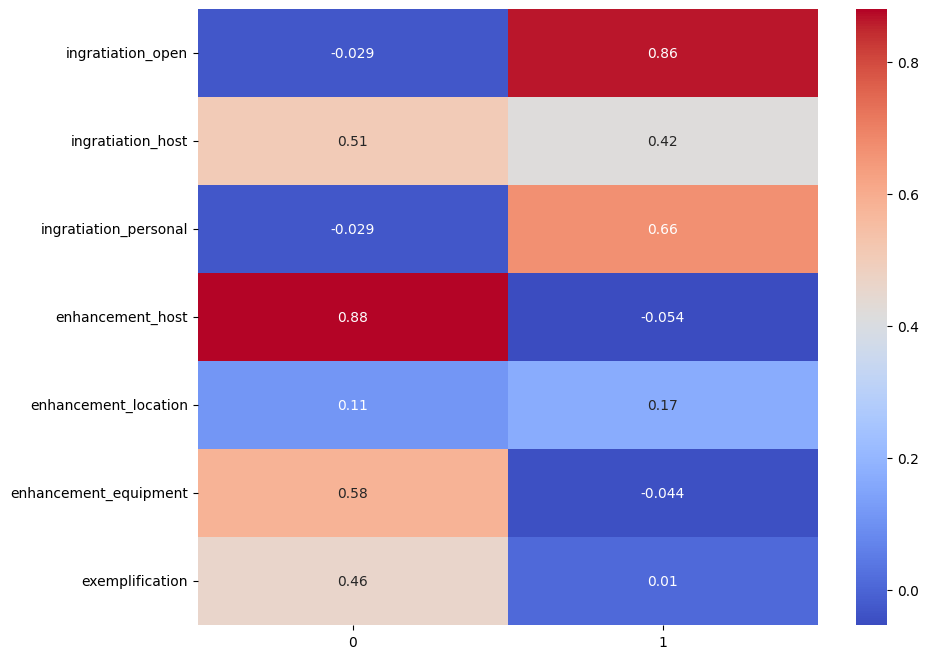

In [33]:
from factor_analyzer import FactorAnalyzer
fa=FactorAnalyzer(n_factors=2, rotation='oblimin')##??
fa.fit(tactics_df)

loadings_tac=fa.loadings_
loadings_tac_df=pd.DataFrame(loadings_tac, index=tactics_df.columns)#, columns=['F1','F2','F3','F4']
display(loadings_tac_df)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(loadings_tac_df, annot=True, cmap='coolwarm')

## 标签代表性文本：skip

In [ ]:
res_en_tac=pd.concat([res_en_, tactics_df],axis=1)
print(len(res_en_tac))
display(res_en_tac.head())

8830


,sp,open to different cultures,love traveling,cosmopolitan,international view,cultural exchange,embrace new experiences,proactive,meet new people,hospitable,...,cosy place,comfortable atmosphere,fan of Airbnb,Airbnb community,ingratiation_open,ingratiation_host,enhancement_host,enhancement_location,enhancement_equipment,exemplification
0,We have spent a lot of time traveling for work...,0.326977,0.872418,0.935198,0.957682,0.588577,0.886424,0.904293,0.111351,0.994318,...,0.149455,0.795043,0.285509,0.021451,0.787793,0.855964,0.782587,0.312431,0.319539,0.163345
1,Independent photographer. \nCyclist. Often on ...,0.270624,0.328453,0.088596,0.766917,0.001054,0.187130,0.834465,0.011969,0.963766,...,0.560010,0.790366,0.095682,0.017927,0.348238,0.547212,0.400509,0.082482,0.418202,0.059709
2,"I am a writer,54, author of novels, books of l...",0.190188,0.000343,0.134246,0.025538,0.012216,0.025344,0.723704,0.000565,0.038492,...,0.009819,0.004549,0.000321,0.043717,0.136704,0.027388,0.105170,0.156258,0.252225,0.020398
3,Hello ! \r\nOur apartment is great and I am su...,0.395662,0.058378,0.051395,0.305252,0.040200,0.888551,0.929559,0.825821,0.981755,...,0.932612,0.886940,0.294099,0.039286,0.372987,0.962791,0.836365,0.079559,0.546158,0.176213
4,We are web startup entrepreneurs and bnb/garde...,0.510264,0.021858,0.396760,0.800904,0.027181,0.926755,0.789550,0.026181,0.791855,...,0.150021,0.079634,0.541627,0.886296,0.513381,0.433623,0.224248,0.246155,0.175579,0.701084


In [169]:
labels_exemples=pd.DataFrame()
for label in labels_list :
       print(label)
       data = res_en_tac.sort_values(by=f'{label}', ascending=False).head(5)                                                               
       labels_exemples=pd.concat([labels_exemples, data], axis=0)
       #break #chq label
display(labels_exemples.head())

labels_exemples.to_csv('D:\Master_ENC\mini_memoire/res_tactiques2/3labels_exempels_5.csv',index=False)

open to different cultures
love traveling
cosmopolitan
international view
cultural exchange
embrace new experiences
proactive
meet new people
hospitable
welcoming
friendly
sociable
interpersonal interaction
experienced host
thoughtful service
attentive to needs
give advices
willing to help
central location
close to attraction
close to restaurants
close to transport connections
lively neighborhood
well-equipped
well-decorated
well-maintained
cosy place
comfortable atmosphere
fan of Airbnb
Airbnb community


,sp,open to different cultures,love traveling,cosmopolitan,international view,cultural exchange,embrace new experiences,proactive,meet new people,hospitable,...,cosy place,comfortable atmosphere,fan of Airbnb,Airbnb community,ingratiation_open,ingratiation_host,enhancement_host,enhancement_location,enhancement_equipment,exemplification
5388,I speak french and english and a little bit sp...,0.998097,0.994117,0.939867,0.989370,0.972951,0.940661,0.613309,0.753842,0.981817,...,0.020366,0.699098,0.006242,0.026203,0.934790,0.874134,0.420753,0.220613,0.198437,0.015477
2632,"Hi ! I am Baudouin, originally from Paris. \r\...",0.995716,0.981868,0.923778,0.977331,0.815365,0.930558,0.837759,0.940765,0.998028,...,0.016947,0.053635,0.286144,0.051816,0.933877,0.979480,0.897470,0.175759,0.118610,0.177735
1561,"Retired by now , French and very opened to th...",0.993908,0.970635,0.889541,0.987155,0.823968,0.946132,0.903286,0.212848,0.442747,...,0.024591,0.051250,0.019030,0.067419,0.938044,0.463933,0.089266,0.161856,0.052472,0.041417
4805,"Soy una chica de 31 años, simpática, agradable...",0.993452,0.039903,0.935975,0.953279,0.914720,0.977841,0.849546,0.998304,0.969222,...,0.010946,0.903462,0.002025,0.164653,0.809016,0.991428,0.257164,0.128760,0.283959,0.077263
633,Like to share multi cultural experiences and w...,0.992692,0.227157,0.943338,0.967092,0.996780,0.991195,0.607746,0.992361,0.691944,...,0.000495,0.005652,0.000954,0.042302,0.825722,0.891155,0.064351,0.062394,0.046576,0.020083


## CFA :skip

EFA 可能会把因子归到不同的策略上，和我们预想的不一样，所以调整因子的位置。得到明确的归属之后用cfa再次验证？

无法直接用cfa，因为即使我们知道因子的归属，也可能是不准确的！

In [ ]:
from semopy import Model, Optimizer
import pandas as pd

# 模型公式
print("EFA avec espace:",data_efa.columns)
data_cfa=data_efa.copy()
data_cfa.columns=[col.replace(' ', '_').replace('-', '_')for col in data_cfa.columns]
print('CFA sans espace:', data_cfa.columns)



model_desc = """
# Ingratiation Open
ingratiation_open =~ open_to_different_cultures + love_traveling + cosmopolitan + international_view + cultural_exchange + embrace_new_experiences + proactive

# Ingratiation Host
ingratiation_host =~ meet_new_people + hospitable + welcoming + friendly + sociable + interpersonal_interaction

# Enhancement Host
enhancement_host =~ experienced_host + thoughtful_service + attentive_to_needs + give_advices + willing_to_help

# Enhancement Location
enhancement_location =~ central_location + close_to_attraction + close_to_restaurants + close_to_transport_connections + lively_neighborhood

# Enhancement Equipment
enhancement_equipment =~ well_equipped + well_decorated + well_maintained + cosy_place + comfortable_atmosphere

# Exemplification
exemplification =~ fan_of_Airbnb + Airbnb_community
"""

# 构建模型
model = Model(model_desc)
model.fit(data_cfa)

# 查看结果
estimates = model.inspect()
print(estimates)

# 拟合指标
from semopy import calc_stats
stats = calc_stats(model)
display(stats)

#模型拟合的不好！！！
#chi2应该小，
# CFI 一般应该大于 0.90，接近 0.95 更好。
# GFI（Goodness of Fit Index） 和 AGFI（Adjusted Goodness of Fit Index） 都应该大于 0.90。
# TLI（Tucker-Lewis Index），通常大于 0.90，越接近 1 越好。
#MSEA < 0.05 被认为是优秀拟合，0.05 < RMSEA < 0.08 被认为是适度拟合，RMSEA > 0.08 就表示拟合较差。
#AIC（Akaike Information Criterion） 和 BIC（Bayesian Information Criterion） 是评估模型复杂度的指标。它们值越小，模型的拟合效果越好。
#对数似然值越大表示模型拟合越好。

EFA avec espace: Index(['open to different cultures', 'love traveling', 'cosmopolitan',
       'international view', 'cultural exchange', 'embrace new experiences',
       'proactive', 'meet new people', 'hospitable', 'welcoming', 'friendly',
       'sociable', 'interpersonal interaction', 'experienced host',
       'thoughtful service', 'attentive to needs', 'give advices',
       'willing to help', 'central location', 'close to attraction',
       'close to restaurants', 'close to transport connections',
       'lively neighborhood', 'well-equipped', 'well-decorated',
       'well-maintained', 'cosy place', 'comfortable atmosphere',
       'fan of Airbnb', 'Airbnb community'],
      dtype='object')
CFA sans espace: Index(['open_to_different_cultures', 'love_traveling', 'cosmopolitan',
       'international_view', 'cultural_exchange', 'embrace_new_experiences',
       'proactive', 'meet_new_people', 'hospitable', 'welcoming', 'friendly',
       'sociable', 'interpersonal_interaction',

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,390,435,45871.600077,0.0,180439.838593,0.747331,0.745779,0.716446,0.745779,0.718177,0.114929,139.610057,671.053329,5.194972


# le cercle de corrélation :

## 先降维N个因子降维到2，再画cc！

In [34]:
from sklearn.decomposition import PCA ##主成分分析降维！
import matplotlib.pyplot as plt
import numpy as np


pca=PCA(n_components=2)
loadings_2d=pca.fit_transform(loadings)
print(f"Explained variance ratio:{pca.explained_variance_ratio_.sum()}")

##第一个 PCA 维度 解释了 30.20% 的信息，第二个 PCA 维度 解释了 22.04% 的信息，两者合起来解释了 52.25% 的信息。
##能保留 50%~60% 的信息，属于正常情况，尤其在社会科学、心理学领域。如果能达到 70% 以上，会更好（但不常见）
## 箭头方向聚类、分组清晰 ➜ 图就很有用。


Explained variance ratio:0.41963367455139766


##  2D

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


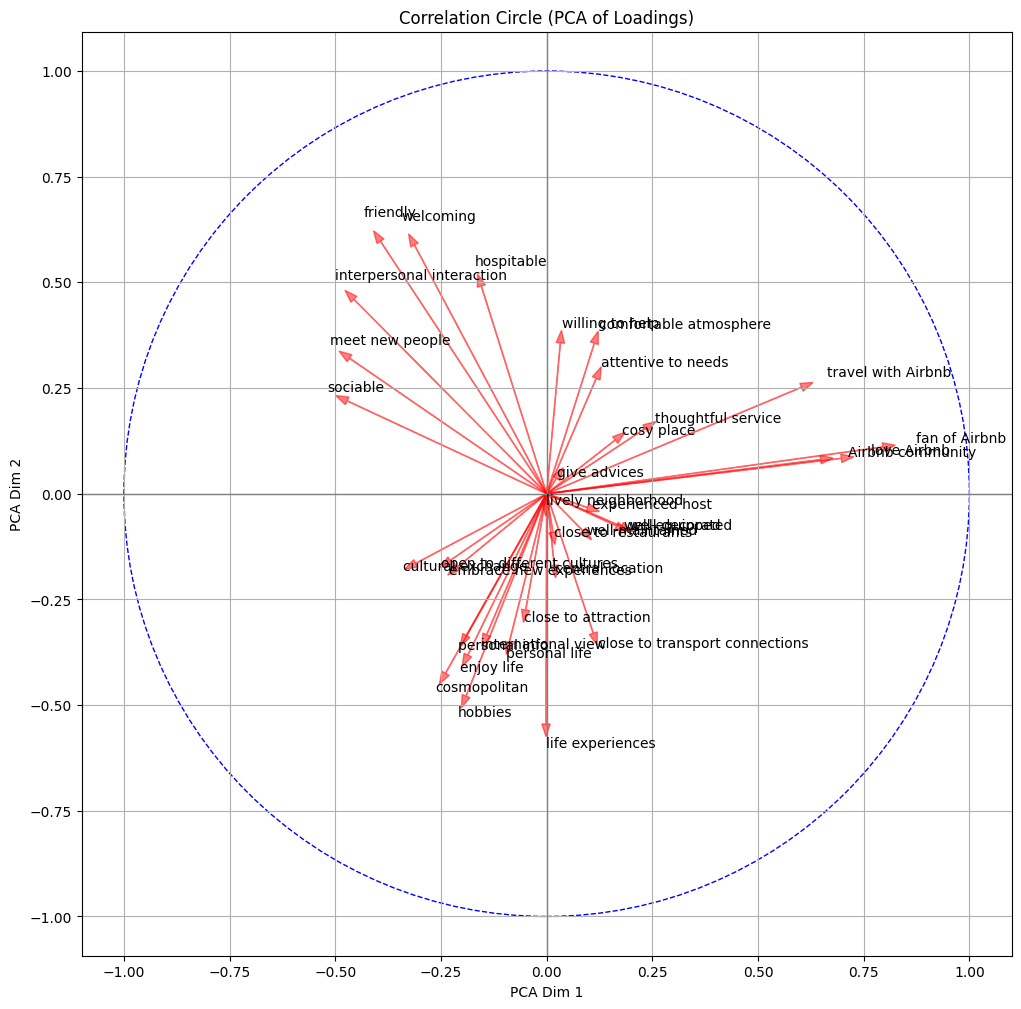

In [35]:
plt.figure(figsize=(12, 12))
# 画单位圆
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# 坐标轴
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# PCA画箭头
for i, var in enumerate(data.columns):
    plt.arrow(0, 0, loadings_2d[i, 0], loadings_2d[i, 1], 
              color='red', alpha=0.5, head_width=0.02)
    plt.text(loadings_2d[i, 0]*1.1, loadings_2d[i, 1]*1.1, var, fontsize=10)


plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Correlation Circle (PCA of Loadings)')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='datalim')
plt.show()


###

Explained variance ratios (3D): 0.6010770136336612


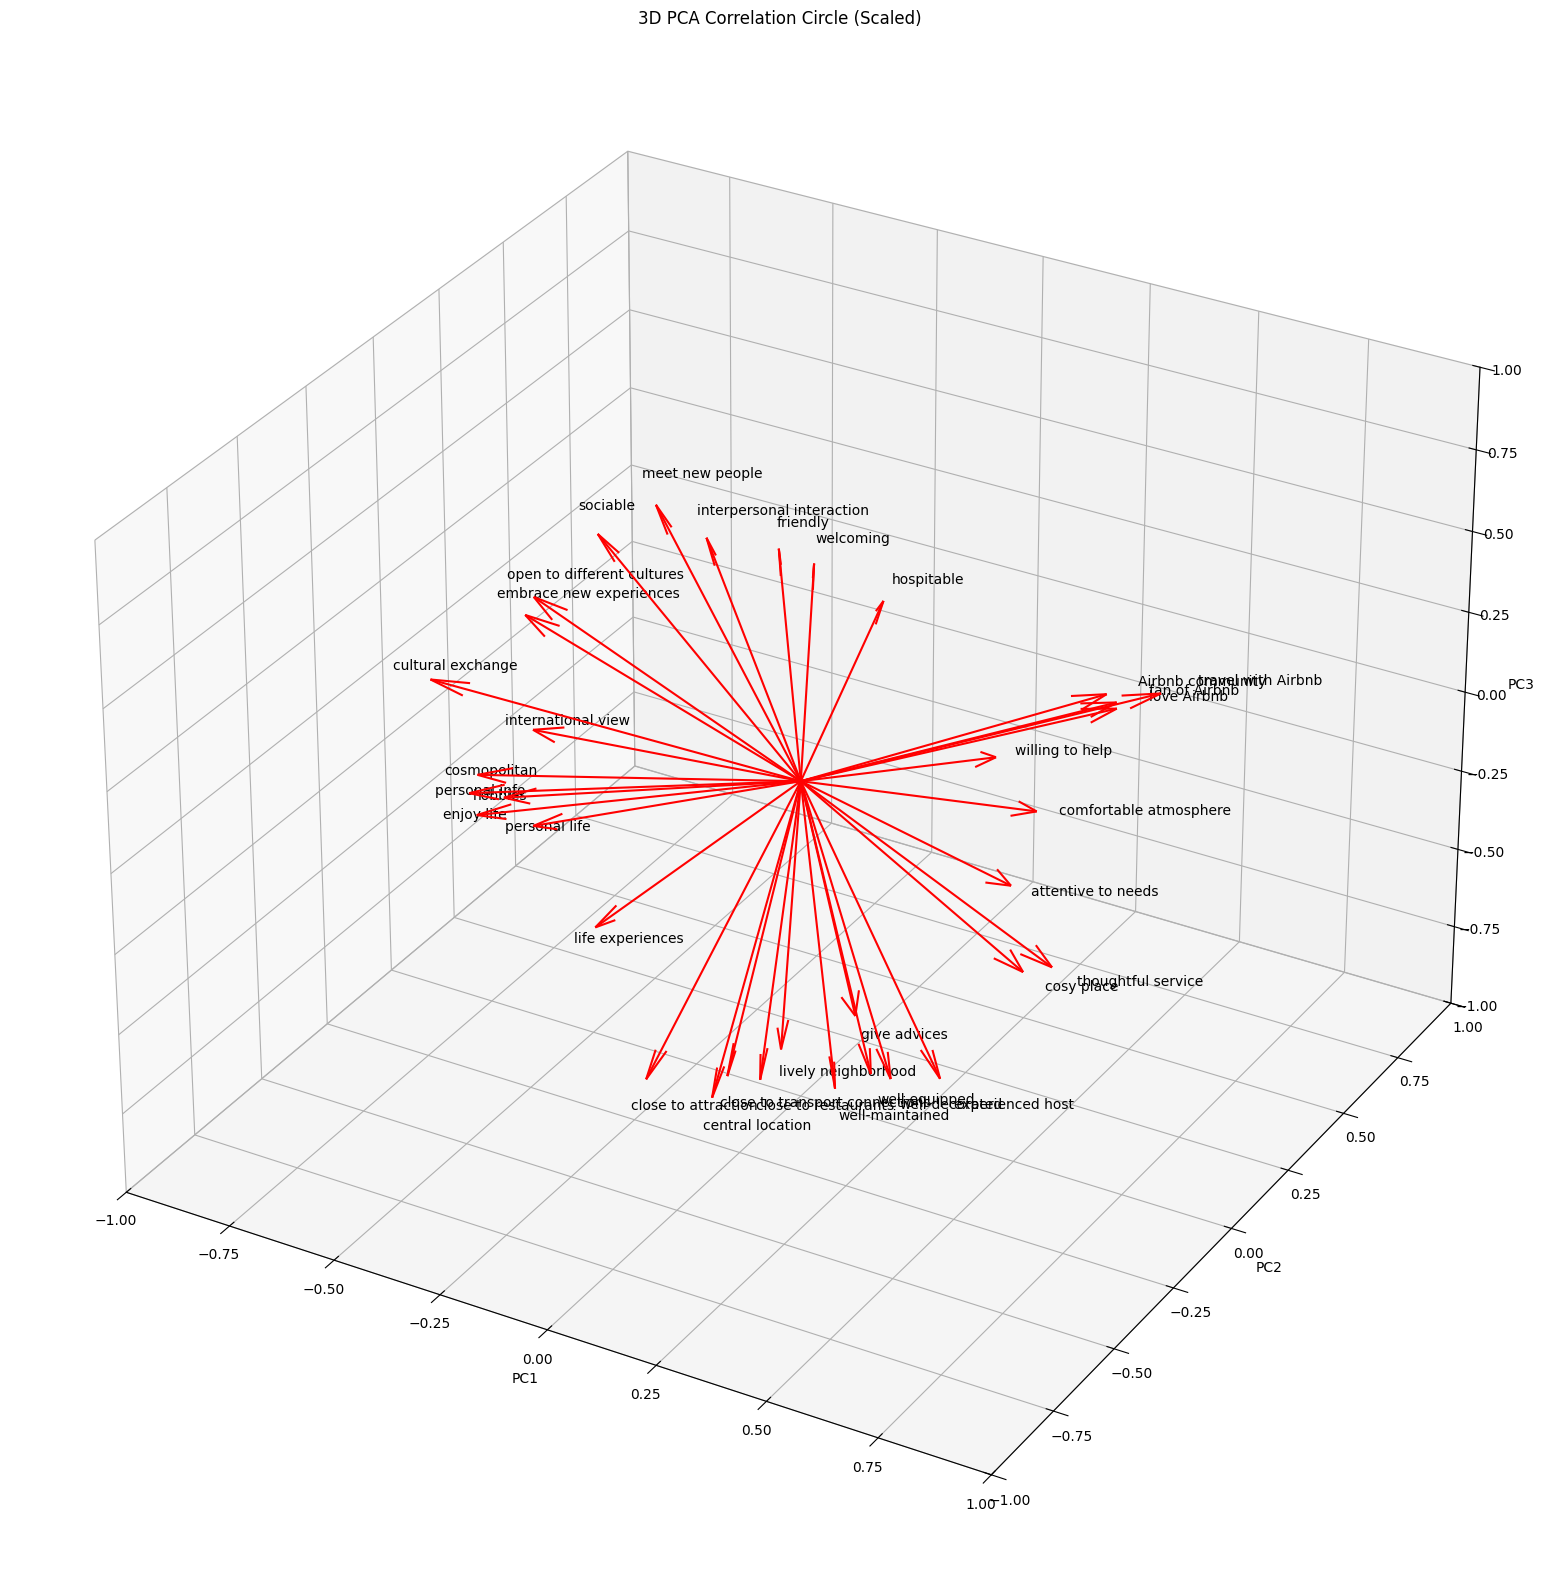

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_3d=PCA(n_components=3)
loadings_3d=pca_3d.fit_transform(loadings)
print("Explained variance ratios (3D):", pca_3d.explained_variance_ratio_.sum())


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# 缩放向量
norms = np.linalg.norm(loadings_3d, axis=1)
loadings_3d_scaled = loadings_3d / norms[:, np.newaxis] * 0.8


# 画箭头
for i, var in enumerate(data.columns):
    ax.quiver(0, 0, 0,
              loadings_3d_scaled[i, 0], 
              loadings_3d_scaled[i, 1], 
              loadings_3d_scaled[i, 2], 
              color='red', arrow_length_ratio=0.1)
    
    ax.text(loadings_3d_scaled[i, 0]*1.1, 
            loadings_3d_scaled[i, 1]*1.1, 
            loadings_3d_scaled[i, 2]*1.1, 
            var, fontsize=10)

# 坐标轴限制
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title('3D PCA Correlation Circle (Scaled)')
plt.show()

## textes représentatifs :

In [107]:
top_5 = res_en_.sort_values(by='offer recommendations', ascending=False).head(5)
print("得分前5名的sp句子：")
print(top_5[['sp', 'offer recommendations']])
sp_sentences = top_5['sp']

with open('D:\MASTER_ENC\mini_memoire/res_tactiques2/top_recommendations.txt', 'w', encoding='utf-8') as f:
    for sentence in sp_sentences:
        f.write(sentence + '\n\n')

得分前5名的sp句子：
                                                     sp  offer recommendations
779   Happy to help and recommend Paris nicest tours...               0.998990
612   Born in Paris.\r\nLiving in Los Angeles\r\n\r\...               0.998484
2018  Raised and born in Paris, and also musician, I...               0.998159
7520  Las mejores recomendaciones de paris de primer...               0.997725
8757  working in the art field i can advice you  for...               0.997431


In [113]:
# 找出得分大于 0.8 的行
threshold = 0.6
high_score_rows1 = res_en_[res_en_['offer recommendations'] > threshold]
print(len(high_score_rows1)/len(res_en_))

high_score_rows2 = res_en_[res_en_['experienced host'] > threshold]
print(len(high_score_rows2)/len(res_en_))


high_score_rows3 = res_en_[res_en_['hospitable'] > threshold]
print(len(high_score_rows3)/len(res_en_))


# print(f"得分大于{threshold}的sp句子：")
# texts=high_score_rows[['sp', 'offer recommendations']]
# print(texts)


0.2088335220838052
0.23691959229898074
0.6276330690826727
